# Klasteryzacja zbioru testowego

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import skfuzzy as fuzz
from sklearn.metrics import fowlkes_mallows_score
import math

# Przygotowanie danych

In [2]:
pd.options.display.max_rows = 10

ratings = pd.read_csv(Path('..','..','res','data','ratings.csv'))

users = pd.read_csv(Path('..','..','res','data','users.csv'))

movies = pd.read_csv(Path('..','..','res','data','movies.csv'))


# zmiana napisów na liczby
label_encoder = LabelEncoder()
users['gender'] = label_encoder.fit_transform(users['gender'])
users['occupation'] = label_encoder.fit_transform(users['occupation'])

## macierz ocen

In [3]:
ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')


## podział na testowe i treningowe

In [4]:
train_set, test_set = train_test_split(ratings_matrix, test_size=0.2)#, random_state=42)

users_train = users[~users['user_id'].isin(test_set.index.to_list())]
items_train = ratings[~ratings['user_id'].isin(test_set.index.to_list())]

users_test = users[users['user_id'].isin(test_set.index.to_list())]
items_test = ratings[ratings['user_id'].isin(test_set.index.to_list())]


In [5]:
train_set.to_csv(Path('..','..','outputs','train_set.csv'), index = False)
test_set.to_csv(Path('..','..','outputs','test_set.csv'), index = False)

## znalezienie optymalnej liczby klastrów dla K-Modes

In [6]:
data_to_clustering = users_train[['age','gender','occupation']]

K = range(1,10)
repeat = 10
clustering_quality = np.zeros((repeat, K[-1]))

for j in range(repeat):
    for k in K:
        k_modes = KModes(n_clusters=k, init='Huang', n_init=5, verbose=1, random_state=42)
        clusters = k_modes.fit_predict(data_to_clustering)
        clustering_quality[j,k-1] = k_modes.cost_
        
avg_clust_quality =np.mean(clustering_quality, axis=0) #średnia po kolumnach

plt.plot(K, avg_clust_quality, 'x-')
plt.xlabel("Liczba clustrów")
plt.ylabel("Koszt")

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1546.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 1546.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 1546.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 1546.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 1546.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3, cost: 1441.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1, cost: 1509.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Ru

KeyboardInterrupt: 

# Funkcje 

In [7]:
def cluster_items(items_info):
    data_to_cluster = items_info[['movie_id','rating']]
    K_FCM = 100
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_to_cluster.T, K_FCM, 2, error=0.005, maxiter=1000)
    clusters = np.argmax(u, axis=0)
    items_info['cluster'] = clusters
    return(items_info)

In [8]:
def cluster_users(users_info):
    data_to_cluseter = users_info[['age','gender','occupation']]
    kmode = KModes(n_clusters=5, init = "random", n_init = 5, verbose=1, random_state=42) 
    clusters = kmode.fit_predict(data_to_cluseter) 
    users_info['cluster'] = clusters
    return(users_info)

In [9]:
def IP(train_numpy, items_clustered):
    
    #obliczanie item popularity
    #szukanie IPmax
    IP = np.sum(train_numpy, axis = 0)
    IP = IP.reshape(1,-1)
    IPmax = np.amax(IP)
    IPmax_coordinates = np.argmax(IP) + 1 #bo filmy mają indeksy od 1
    
    #znalezienie clustra IPmax i należących do niego elementów
    IPmax_cluster = items_clustered[items_clustered['movie_id'] == IPmax_coordinates].iloc[0,4]
    max_clust_movies = items_clustered[items_clustered['cluster'] == IPmax_cluster]['movie_id'].to_list()
    max_clust_movies = list(set(max_clust_movies))
    IP_dash = IP[:,np.array(max_clust_movies) - 1] / IPmax
    return(IP_dash, max_clust_movies)
    

In [10]:
def UP_HP(train_set, cluster, clust_data, IP_dash, alpha):
    
    #znalezienie starych użytkowników w danym clustrze
    users_in_cluster = clust_data[clust_data['cluster'] == cluster]['user_id'].to_list()
    users_in_cluster = list(set(users_in_cluster))

    #macierz ratingów tylko dla tych userów
    dd = train_set[train_set.index.isin(users_in_cluster)]
    ratings_matrix_cluster = train_set[train_set.index.isin(users_in_cluster)].to_numpy()

    #obliczanie user popularity
    UP = np.sum(ratings_matrix_cluster, axis=1) ##sumowanie po wierszach
    UP = UP.reshape(-1,1)
    UPmax = np.amax(UP)
    UPmax_coordinates = np.argmax(UP)
    UP_dash = UP / UPmax
    
    # obliczenie UIP i hybrydy
    UIP = UP_dash / IP_dash
    HP = alpha * IP_dash + (1-alpha) * np.sum(UIP,axis = 0).reshape(1,-1)
    
    return(HP)

In [11]:
def HP_for_clust(test_set, train_set, alpha):
    
    #zastąpienie nan zerami
    train_set = train_set.fillna(0)
    test_set = test_set.fillna(0)
    train_numpy = train_set.to_numpy()
    test_numpy = test_set.to_numpy()

    #zbiory treningowe
    users_train = users[~users['user_id'].isin(test_set.index.to_list())]
    items_train = ratings[~ratings['user_id'].isin(test_set.index.to_list())]
    
    #zbiory testowe
    users_test = users[users['user_id'].isin(test_set.index.to_list())]
    items_test = ratings[ratings['user_id'].isin(test_set.index.to_list())]
    
    #podział na clustry
    #users_clustered = cluster_users(users_train.copy())
    #items_clustered = cluster_items(items_train.copy())
    
    users_clustered = pd.read_csv(Path('..','..','outputs','users_train_clustered.csv'))
    items_clustered = pd.read_csv(Path('..','..','outputs','items_train_clustered.csv'))
        
    #przypisanie nowych użytkowników do clustrów
    kmode = KModes(n_clusters=5, init = "random", n_init = 5, verbose=1, random_state=42) 
    train_clusters = kmode.fit_predict(users_train)
    test_users_clusters = kmode.predict(users_test)
    test_users_clustered = users_test.copy() ##OCEŃ CZY KOPIOWANIE JEST KONIECZNE
    test_users_clustered['cluster'] = test_users_clusters
    
    IP_results = IP(train_numpy, items_clustered)
    IP_dash = IP_results[0]
    movies_from_max_cluster = IP_results[1]
    clust_HP = {0:None,
                1:None,
                2:None,
                3:None,
                4:None}
    
    for cl in list(set(test_users_clusters)):
        HP = UP_HP(train_set, cl, users_clustered, IP_dash, alpha)[0].tolist()  
        clust_HP[cl] = (movies_from_max_cluster, HP)
    
    return(clust_HP, test_users_clustered)

In [12]:
HP_dict = HP_for_clust(test_set, train_set, 0.5)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 88, cost: 2637.0
Run 1, iteration: 2/100, moves: 10, cost: 2629.0
Run 1, iteration: 3/100, moves: 5, cost: 2629.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 215, cost: 2707.0
Run 2, iteration: 2/100, moves: 10, cost: 2707.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 207, cost: 2693.0
Run 3, iteration: 2/100, moves: 10, cost: 2693.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 8, cost: 2736.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 35, cost: 2674.0
Best run was number 1


In [13]:
HP_and_movies = HP_dict[0]
test_cl = HP_dict[1]
grupowane = test_cl.groupby('cluster').agg(users_in_cluster = ('cluster','size')).reset_index()
users_per_cluster = test_cl.groupby('cluster')['user_id'].apply(list).to_dict()

In [14]:
num_users_per_cluster = grupowane.set_index('cluster')['users_in_cluster'].to_dict()
num_users_per_cluster # liczba użytkowników w każdym clustrze
HP_and_movies ## filmy do polecenia i HP dla danego clustra
users_per_cluster # użytkownicy w każdym cclustrze

{0: [4,
  7,
  8,
  9,
  22,
  45,
  57,
  58,
  60,
  67,
  68,
  76,
  78,
  91,
  97,
  100,
  104,
  107,
  110,
  112,
  116,
  124,
  134,
  139,
  144,
  148,
  153,
  163,
  194,
  197,
  219,
  220,
  227,
  234,
  237,
  245,
  246,
  252,
  255,
  257,
  267,
  276,
  279,
  293,
  308,
  309,
  313,
  318,
  327,
  332,
  335,
  343,
  364,
  365,
  367,
  368,
  370,
  371,
  374,
  380,
  382,
  383,
  384,
  402,
  405,
  428,
  431,
  441,
  448,
  458,
  464,
  471,
  472,
  474,
  493,
  506,
  511,
  517,
  565,
  566,
  575,
  576,
  580,
  582,
  584,
  585,
  595,
  616,
  627,
  628,
  635,
  664,
  680,
  706,
  711,
  714,
  717,
  723,
  728,
  739,
  741,
  746,
  752,
  776,
  779,
  780,
  808,
  821,
  823,
  830,
  850,
  863,
  871,
  881,
  889,
  916],
 1: [13,
  15,
  65,
  90,
  126,
  171,
  187,
  247,
  315,
  321,
  412,
  413,
  540,
  555,
  570,
  593,
  606,
  691,
  791,
  858,
  903],
 2: [18,
  120,
  136,
  155,
  165,
  273,
  346,
  360

In [15]:
users_list = []
items_list = []
ratings_list = []

test_users_dictionary = {'user_id':[],
                         'movie_id':[],
                         'rating':[]}
    
for cl in users_per_cluster.keys():
    num_of_users = num_users_per_cluster[cl]
    num_of_items = len(HP_and_movies[cl][0])
    
    multiplied_users = users_per_cluster[cl] * num_of_items
    multiplied_users.sort()
    test_users_dictionary['user_id'].extend(multiplied_users)
    users_list.append(multiplied_users)
    #aktualizuję uzytkowników w clustrze powielając ich tyle razy ile jest przedmiotów, 
    #bo każdy musi dany przedmiot mieć oceniony
    users_per_cluster[cl] = multiplied_users
    
    #powielam przedmioty i oceny tyle razy ilu jest użytkowników
    HP_and_movies[cl] = (HP_and_movies[cl][0] * num_of_users, HP_and_movies[cl][1] * num_of_users)
    items_list.append(HP_and_movies[cl][0])
    ratings_list.append(HP_and_movies[cl][1])
    test_users_dictionary['movie_id'].extend(HP_and_movies[cl][0])
    test_users_dictionary['rating'].extend(HP_and_movies[cl][1])
    print(len(users_per_cluster[cl]), len(HP_and_movies[cl][0]), len(HP_and_movies[cl][1]))
    


2436 2436 2436
441 441 441
567 567 567
399 399 399
126 126 126


In [16]:
for el in test_users_dictionary.keys():
    print(len(test_users_dictionary[el]))

3969
3969
3969


In [17]:
test_ratings_HP = pd.DataFrame(test_users_dictionary)
test_ratings_HP.to_csv(Path('..','..','outputs','test_ratings.csv'), index=False)
test_ratings_matrix = test_ratings_HP.pivot(index='user_id', columns='movie_id', values='rating')
HP_columns = test_ratings_matrix.columns
test_ratings_matrix

movie_id,38,39,40,41,42,43,44,45,46,47,...,49,50,51,52,53,54,55,56,57,58
user_id,,,,,,,,,,,,,,,,,,,,,
4,97.218534,116.399952,223.689183,310.256930,61.898438,277.446534,128.858656,110.608629,374.717018,73.699916,...,133.011809,15.012937,122.312404,113.653329,96.569245,106.532067,63.664227,22.862337,234.597758,55.828581
7,97.218534,116.399952,223.689183,310.256930,61.898438,277.446534,128.858656,110.608629,374.717018,73.699916,...,133.011809,15.012937,122.312404,113.653329,96.569245,106.532067,63.664227,22.862337,234.597758,55.828581
8,97.218534,116.399952,223.689183,310.256930,61.898438,277.446534,128.858656,110.608629,374.717018,73.699916,...,133.011809,15.012937,122.312404,113.653329,96.569245,106.532067,63.664227,22.862337,234.597758,55.828581
9,97.218534,116.399952,223.689183,310.256930,61.898438,277.446534,128.858656,110.608629,374.717018,73.699916,...,133.011809,15.012937,122.312404,113.653329,96.569245,106.532067,63.664227,22.862337,234.597758,55.828581
13,231.050753,276.674827,531.814524,737.656597,147.012290,659.640467,306.305839,262.900465,890.927005,175.098306,...,316.183095,35.006986,290.736849,270.142183,229.506266,253.204278,151.215260,53.915594,557.753604,132.562498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,68.678990,82.221546,157.981860,219.114514,43.748021,195.944181,91.018278,78.132596,264.635918,52.076843,...,93.950773,10.749233,86.396113,80.282287,68.220601,75.254412,44.994085,16.240271,165.685200,39.465175
916,97.218534,116.399952,223.689183,310.256930,61.898438,277.446534,128.858656,110.608629,374.717018,73.699916,...,133.011809,15.012937,122.312404,113.653329,96.569245,106.532067,63.664227,22.862337,234.597758,55.828581
924,53.080653,63.541280,122.069410,169.300471,33.827880,151.398931,70.336555,60.382765,204.470905,40.258715,...,72.601898,8.418898,66.766002,62.043287,52.726601,58.159556,34.789887,12.620969,128.020923,30.521727


In [18]:
test_set.columns.isin(HP_columns)

array([False, False, False, ..., False, False, False])

In [377]:
test_set = test_set.fillna(0)
test_set_limited = test_set[test_set.columns[test_set.columns.isin(HP_columns)]]
test_set_limited.to_csv(Path('..','..','outputs','test_set_limited.csv'), index=False)


In [76]:
test_set

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,4.0,0.0,0.0,4.0,0.0,0.0,2.0,4.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
365,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
testowy_bardzo = test_set.iloc[10:15,7:17]
testowy_bardzo

movie_id,8,9,10,11,12,13,14,15,16,17
user_id,,,,,,,,,,
616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
881,4.0,3.0,0.0,4.0,0.0,4.0,1.0,3.0,0.0,0.0


In [297]:
def find_topN_items(users_ratings,N):

    original_indices = users_ratings.index #oryginalne indeksy
    topN = users_ratings.nlargest(N) #N najlepiej ocenianych filmów (rating i indeks)
    topN_indices = topN.index #indeksy tych najlepiej ocenianych
    zero_mask = users_ratings == 0 #maska do tych miejsc gdzie user_rating jest zero
    zero_indices = users_ratings[zero_mask].index #indeksy tego gdzie jest zero
    mask = users_ratings.index.isin(topN_indices) #maska na te ratingi i indeksy które wchodza w skład topN
    #users_ratings = pd.Series([0 for i in range(len(users_ratings))], index = original_indices)
    #users_ratings[mask] = 1
    #users_ratings[zero_indices] = 0
    
    #print(users_ratings[topN_indices][users_ratings[topN_indices]<5])
    top_nonzero_indices = users_ratings[topN_indices][users_ratings[topN_indices] > 0].index
    users_ratings["topN_movies"] = top_nonzero_indices.values
    
    return users_ratings

In [387]:
def show_Hu(row, u, N):
    nonzero = row[row > 0].index
    nonzero_indices = nonzero.values
    row['Hu'] = nonzero_indices
    return row

In [391]:
test_set_top = test_set.apply(lambda row: show_Hu(row, 2, 10), axis = 1)

In [392]:
test_ratings_matrix_top = test_ratings_matrix.apply(lambda row: find_topN_items(row, N=10), axis = 1)

In [393]:
test_to_merge = test_set_top.iloc[:,[-1]]
test_to_merge

merged = pd.merge(test_ratings_matrix_top, test_to_merge, on='user_id', how = 'left')
merged

movie_id,38,39,40,41,42,43,44,45,46,47,...,51,52,53,54,55,56,57,58,topN_movies,Hu
user_id,,,,,,,,,,,,,,,,,,,,,
4,97.218534,116.399952,223.689183,310.256930,61.898438,277.446534,128.858656,110.608629,374.717018,73.699916,...,122.312404,113.653329,96.569245,106.532067,63.664227,22.862337,234.597758,55.828581,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[11, 50, 210, 258, 260, 264, 271, 288, 294, 30..."
7,97.218534,116.399952,223.689183,310.256930,61.898438,277.446534,128.858656,110.608629,374.717018,73.699916,...,122.312404,113.653329,96.569245,106.532067,63.664227,22.862337,234.597758,55.828581,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[4, 7, 8, 9, 10, 11, 12, 22, 23, 25, 27, 28, 2..."
8,97.218534,116.399952,223.689183,310.256930,61.898438,277.446534,128.858656,110.608629,374.717018,73.699916,...,122.312404,113.653329,96.569245,106.532067,63.664227,22.862337,234.597758,55.828581,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[7, 11, 22, 50, 55, 56, 79, 82, 89, 96, 127, 1..."
9,97.218534,116.399952,223.689183,310.256930,61.898438,277.446534,128.858656,110.608629,374.717018,73.699916,...,122.312404,113.653329,96.569245,106.532067,63.664227,22.862337,234.597758,55.828581,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[6, 7, 50, 201, 242, 276, 286, 294, 298, 340, ..."
13,231.050753,276.674827,531.814524,737.656597,147.012290,659.640467,306.305839,262.900465,890.927005,175.098306,...,290.736849,270.142183,229.506266,253.204278,151.215260,53.915594,557.753604,132.562498,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 21, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,68.678990,82.221546,157.981860,219.114514,43.748021,195.944181,91.018278,78.132596,264.635918,52.076843,...,86.396113,80.282287,68.220601,75.254412,44.994085,16.240271,165.685200,39.465175,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[7, 21, 26, 82, 83, 87, 89, 93, 98, 99, 102, 1..."
916,97.218534,116.399952,223.689183,310.256930,61.898438,277.446534,128.858656,110.608629,374.717018,73.699916,...,122.312404,113.653329,96.569245,106.532067,63.664227,22.862337,234.597758,55.828581,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[1, 2, 3, 4, 5, 7, 9, 11, 12, 14, 17, 22, 23, ..."
924,53.080653,63.541280,122.069410,169.300471,33.827880,151.398931,70.336555,60.382765,204.470905,40.258715,...,66.766002,62.043287,52.726601,58.159556,34.789887,12.620969,128.020923,30.521727,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[1, 2, 6, 7, 9, 12, 13, 28, 31, 50, 56, 64, 71..."


In [399]:
merged[merged['NDCG'] > 0]

movie_id,38,39,40,41,42,43,44,45,46,47,...,54,55,56,57,58,topN_movies,Hu,NDCG,Precision,Recall
user_id,,,,,,,,,,,,,,,,,,,,,
7,97.218534,116.399952,223.689183,310.256930,61.898438,277.446534,128.858656,110.608629,374.717018,73.699916,...,106.532067,63.664227,22.862337,234.597758,55.828581,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[4, 7, 8, 9, 10, 11, 12, 22, 23, 25, 27, 28, 2...",0.049064,40.0,0.992556
13,231.050753,276.674827,531.814524,737.656597,147.012290,659.640467,306.305839,262.900465,890.927005,175.098306,...,253.204278,151.215260,53.915594,557.753604,132.562498,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 21, ...",0.053843,40.0,0.628931
18,53.080653,63.541280,122.069410,169.300471,33.827880,151.398931,70.336555,60.382765,204.470905,40.258715,...,58.159556,34.789887,12.620969,128.020923,30.521727,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[1, 4, 6, 8, 9, 12, 13, 14, 15, 19, 22, 23, 25...",0.028504,20.0,0.722022
89,14.202346,16.981372,32.558890,45.140718,9.102276,40.371460,18.788086,16.141933,54.511723,10.802447,...,15.551227,9.356281,3.599987,34.144037,8.230497,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[1, 7, 13, 14, 15, 25, 26, 49, 50, 66, 83, 86,...",0.014107,10.0,1.315789
90,231.050753,276.674827,531.814524,737.656597,147.012290,659.640467,306.305839,262.900465,890.927005,175.098306,...,253.204278,151.215260,53.915594,557.753604,132.562498,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[6, 8, 9, 10, 11, 12, 14, 17, 18, 19, 20, 22, ...",0.028504,20.0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,97.218534,116.399952,223.689183,310.256930,61.898438,277.446534,128.858656,110.608629,374.717018,73.699916,...,106.532067,63.664227,22.862337,234.597758,55.828581,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[1, 4, 7, 8, 9, 11, 13, 14, 15, 21, 22, 23, 25...",0.046402,30.0,1.158301
889,97.218534,116.399952,223.689183,310.256930,61.898438,277.446534,128.858656,110.608629,374.717018,73.699916,...,106.532067,63.664227,22.862337,234.597758,55.828581,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 17, 22, 23, ...",0.011922,10.0,0.306748
897,53.080653,63.541280,122.069410,169.300471,33.827880,151.398931,70.336555,60.382765,204.470905,40.258715,...,58.159556,34.789887,12.620969,128.020923,30.521727,"[46, 41, 43, 57, 40, 49, 44, 51, 39, 52]","[1, 8, 11, 22, 23, 25, 28, 33, 40, 50, 55, 56,...",0.015321,10.0,0.540541


In [394]:
def NDCG(row,u,N):
    generated = row.loc['topN_movies']
    from_test_set = row.loc['Hu']
    #sprawdzenie który n-ty element z TopN został irl oceniony przez użytkownika
    available_n = [index + 1  for index, element in enumerate(generated) if element in from_test_set]
    DCG = sum([1 / math.log(1+n,2) for n in available_n])
    IDCG = sum([math.log(1+n,2) for n in range(1,N+1)])
    NDCG = DCG / IDCG
    row['NDCG'] = NDCG
    return row

In [395]:
def Precision_Recall(row, u, N):
    generated = row.loc['topN_movies']
    from_test_set = row.loc['Hu']
    intersection = sum([1 for element in generated if element in from_test_set])
    
    Precision = intersection * 100 / N
    row['Precision'] = Precision
    
    row['Recall'] = intersection * 100 / len(from_test_set)
    return row

# POPRAW ŻE MAJĄ BYĆ BRANE DLA Hu WSZYSTKIE MOŻLIWE FILMY A NIE TYLKO 10

In [398]:
merged = merged.apply(lambda row:  NDCG(row,2,10),axis = 1)
merged = merged.apply(lambda row:  Precision_Recall(row,2,10),axis = 1)

In [354]:
a = [1,2,3]
b = [4,3,5]
[i for i in enumerate(a)]

[index for index, element in enumerate(a) if element in b]

[2]

In [359]:
sum([I for I in range(5)])

10

In [20]:
N = 10


In [302]:
testowy_bardzo

movie_id,8,9,10,11,12,13,14,15,16,17
user_id,,,,,,,,,,
616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
881,4.0,3.0,0.0,4.0,0.0,4.0,1.0,3.0,0.0,0.0


In [301]:
testowy_bardzo.apply(lambda row: find_topN_items(row, N=4), axis = 1)

movie_id,8,9,10,11,12,13,14,15,16,17,topN_movies
user_id,,,,,,,,,,,
616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[]
739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[]
237,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[9]
565,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[10]
881,4.0,3.0,0.0,4.0,0.0,4.0,1.0,3.0,0.0,0.0,"[8, 11, 13, 9]"


In [289]:
topN = testowy_bardzo.loc[881,:].nlargest(8)
topN
non_zero = testowy_bardzo.loc[881,:][testowy_bardzo.loc[881,:] != 0]
non_zero_index = non_zero.nlargest(len(non_zero)).index
non_zero_index, topN.index, topN.index.intersection(non_zero_index).values


(Index([8, 11, 13, 9, 15, 14], dtype='int64', name='movie_id'),
 Index([8, 11, 13, 9, 15, 14, 10, 12], dtype='int64', name='movie_id'),
 array([ 8, 11, 13,  9, 15, 14], dtype=int64))

In [180]:
print(len(ratings_list), len(items_list), len(users_list))

ratings_list = [item for sublist in ratings_list for item in sublist]
users_list = [item for sublist in users_list for item in sublist]
items_list = [item for sublist in items_list for item in sublist]

print(len(ratings_list), len(items_list), len(users_list))

5 5 5
3969 3969 3969


In [134]:
nested_list = [[1, 2, 3], [4, 77, 77], [7, 8, 9]]

# "Rozpakuj" listę list do jednej płaskiej listy
flat_list = [item for sublist in nested_list for item in sublist]

# Wyświetl wynik
print(flat_list)


[1, 2, 3, 4, 77, 77, 7, 8, 9]


In [369]:
for clust in HP_and_movies.keys():
    #multiplied_users = users_per_cluster[int(clust)] * len(HP_and_movies['0'][0])
    #multiplied_users.sort()
    #users_per_cluster[int(clust)]= multiplied_users
    HP_and_movies[clust] = (HP_and_movies[clust][0] * num_users_per_cluster[0], HP_and_movies[clust][1][0].tolist() * num_users_per_cluster[0])
    

In [33]:
def cluster_users(users_info):
    data_to_cluseter = users_info[['age','gender','occupation']]
    kmode = KModes(n_clusters=5, init = "random", n_init = 5, verbose=1, random_state=42) 
    clusters = kmode.fit_predict(data_to_cluseter) 
    users_info['cluster'] = clusters
    return(users_info)

users_clustered = cluster_users(users_train.copy())

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 43, cost: 1212.0
Run 1, iteration: 2/100, moves: 1, cost: 1212.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 22, cost: 1181.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 21, cost: 1187.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 1434.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 50, cost: 1195.0
Best run was number 2


## FCM

In [34]:
def cluster_items(items_info):
    data_to_cluster = items_info[['movie_id','rating']]
    K_FCM = 100
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_to_cluster.T, K_FCM, 2, error=0.005, maxiter=1000)
    clusters = np.argmax(u, axis=0)
    items_info['cluster'] = clusters
    return(items_info)

items_clustered = cluster_items(items_train.copy())

In [179]:
items_clustered.sort_values('user_id')[items_clustered['cluster'] == 49]

NameError: name 'items_clustered' is not defined

In [35]:
users_test.to_csv(Path('..','..','outputs','users_test.csv'), index=False)
users_train.to_csv(Path('..','..','outputs','users_train.csv'), index=False)
items_test.to_csv(Path('..','..','outputs','items_test.csv'), index=False)
items_train.to_csv(Path('..','..','outputs','items_train.csv'), index=False)

users_clustered.to_csv(Path('..','..','outputs','users_train_clustered.csv'), 
                                           index=False)
items_clustered.to_csv(Path('..','..','outputs','items_train_clustered.csv'), 
                                           index=False)

In [36]:
users_test = pd.read_csv(Path('..','..','outputs','users_test.csv'))
users_train = pd.read_csv(Path('..','..','outputs','users_train.csv'))
items_test = pd.read_csv(Path('..','..','outputs','items_test.csv'))
items_train = pd.read_csv(Path('..','..','outputs','items_train.csv'))

users_train_clustered = pd.read_csv(Path('..','..','outputs','users_train_clustered.csv'))
items_train_clustered = pd.read_csv(Path('..','..','outputs','items_train_clustered.csv'))

## przypisanie nowych użytkowników do clustrów

In [37]:
kmode = KModes(n_clusters=5, init = "random", n_init = 5, verbose=1, random_state=42) 
train_clusters = kmode.fit_predict(users_train)
test_users_clusters = kmode.predict(users_test)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 30, cost: 2706.0
Run 1, iteration: 2/100, moves: 9, cost: 2706.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 25, cost: 2670.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 24, cost: 2674.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2, cost: 2922.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 53, cost: 2682.0
Best run was number 2


In [68]:
train_set = train_set.fillna(0)
test_set = test_set.fillna(0)
train_numpy = train_set.to_numpy()

In [69]:
test_users_clustered = users_test.copy()
test_users_clustered['cluster'] = test_users_clusters

sprawdzenie do jakich clustrów należą nowi użytkownicy

In [70]:
list(set(test_users_clusters))

[0, 1, 2, 3, 4]

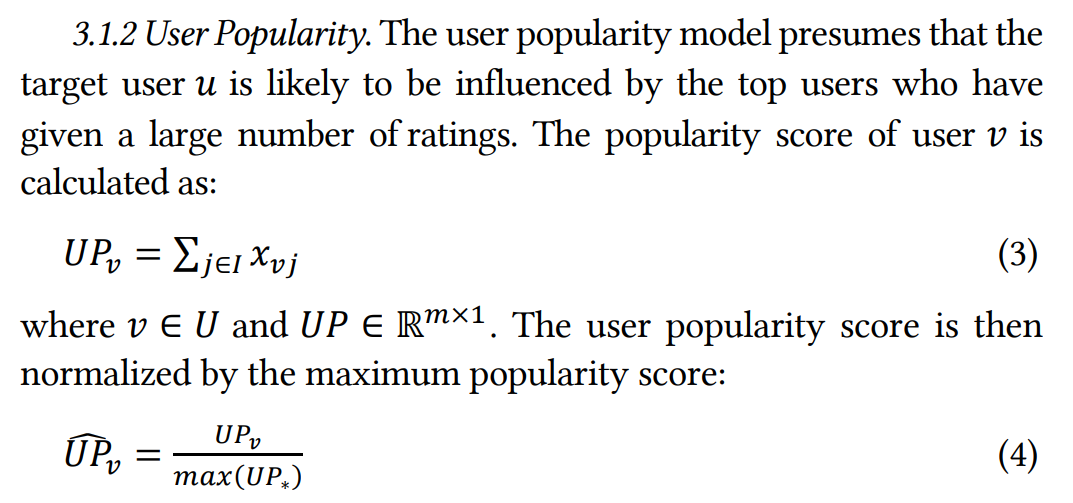

In [71]:
def find_users_in_cluster(clust_data,cluster):
    users_in_cluster = clust_data[clust_data['cluster'] == cluster]['user_id'].to_list()
    users_in_cluster = list(set(users_in_cluster))
    return(users_in_cluster)

users0 = find_users_in_cluster(users_train_clustered, 0)
users1 = find_users_in_cluster(users_train_clustered, 1)
users2 = find_users_in_cluster(users_train_clustered, 2)
users3 = find_users_in_cluster(users_train_clustered, 3)
users4 = find_users_in_cluster(users_train_clustered, 4)

In [72]:
users0_matrix = train_set[train_set.index.isin(users0)]
users1_matrix = train_set[train_set.index.isin(users1)]
users2_matrix = train_set[train_set.index.isin(users2)]
users3_matrix = train_set[train_set.index.isin(users3)]
users4_matrix = train_set[train_set.index.isin(users4)]

In [73]:
def count_UP(clust_data, rating_matrix, cluster):
    # find users in clusters
    users_in_cluster = clust_data[clust_data['cluster'] == cluster]['user_id'].to_list()
    users_in_cluster = list(set(users_in_cluster))
    
    matrix = rating_matrix[rating_matrix.index.isin(users_in_cluster)].to_numpy()
    
    #UP = np.sum(matrix, rows)
    return(matrix)

In [74]:
test = count_UP(users_clustered, train_set, 0)


In [75]:
UP = np.sum(test, axis=1)
UP = UP.reshape(-1,1)

UPmax = np.amax(UP)
UPmax_coordinates = np.argmax(UP)
 
UP_dash = UP / UPmax
UP_dash.shape

(227, 1)

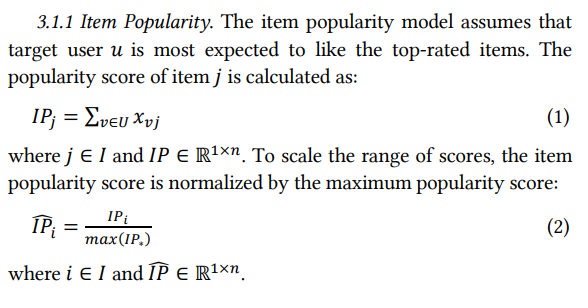

In [153]:
#szukanie IPmax
IP = np.sum(train_numpy, axis = 0)
IP = IP.reshape(1,-1)
IPmax = np.amax(IP)
IPmax_coordinates = np.argmax(IP) 

IPmax, IPmax_coordinates

(1998.0, 49)

In [158]:
IP[0][1]

338.0

IP jest największe dla filmu o id 49. teraz trzeba znalezc, do jakiego clustra należy

In [77]:
IPmax_cluster = items_clustered[items_clustered['movie_id'] == IPmax_coordinates].iloc[0,4]

znajdowanie filmów należących do IPmax_cluster

In [78]:
max_clust_movies = items_clustered[items_clustered['cluster'] == IPmax_cluster]['movie_id'].to_list()
max_clust_movies = list(set(max_clust_movies))

obliczanie IPmax z daszkiem

In [173]:
IP_dash = IP[:,max_clust_movies] / IPmax

In [172]:
IP_dash

array([[0.5995996, 0.5995996]])

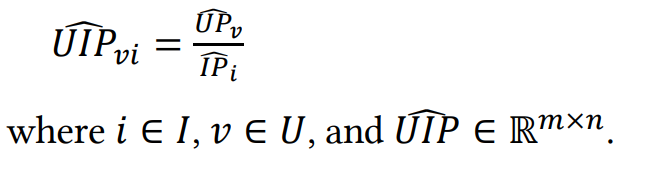

In [81]:
UIP = UP_dash / IP_dash

In [82]:
alpha = 0.8

In [122]:
HP = alpha * IP_dash + (1-alpha) * np.sum(UIP,axis = 0).reshape(1,-1)

In [125]:
N = 10
HP

array([[ 62.74048307, 107.31723409, 164.67278703,  31.99592722,
        147.52696264,  70.52276069,  54.14650156, 172.70232458,
         35.82369025,  36.64736134,  66.87214113,   7.8865357 ,
         62.46489231,  48.7725245 ,  48.93990344,  53.33544757,
         33.17619677,  11.64887612, 100.47417506,  28.40597774,
         49.62115201]])

In [175]:
sorted_array = np.sort(HP)[0][::-1]
top10 = sorted_array[:10]
top10

array([172.70232458, 164.67278703, 147.52696264, 107.31723409,
       100.47417506,  70.52276069,  66.87214113,  62.74048307,
        62.46489231,  54.14650156])

In [201]:
HP.shape

(1, 21)